# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road

## The part immediately follows is problem statement
## To see solution by Jean Tsao, go to "Jean Tsao's Solution" section below

***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


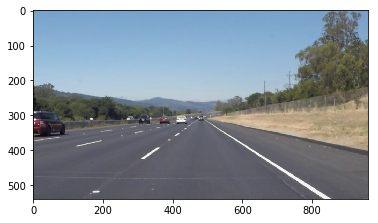

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 
# 'gray', for example, call as plt.imshow(gray, cmap='gray')


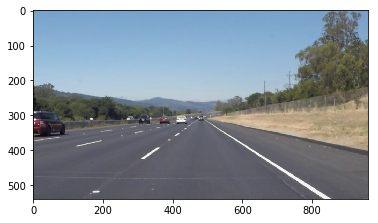

In [3]:
gray = image
plt.imshow(gray, cmap='gray')

This is where openCV uses a different RGB scheme can result in left line showing up as a blue one.

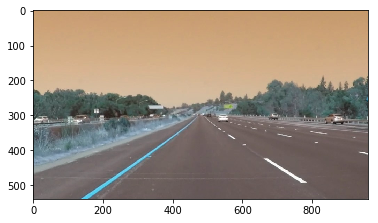

In [4]:
image = cv2.imread('test_images/solidYellowLeft.jpg')
plt.imshow(image)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Apply an image mask.
    
    Keep only the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with      
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting 
    point once you want to average/extrapolate the line segments 
    you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image 
    with lines drawn on it.  Should be a blank image (all black) 
    with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
dirs = os.listdir("test_images/")
#n = len(dirs)
#print(n)
#print(dirs[0])

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

# Jean Tsao Solution Starts Here 

In [7]:
''' Summary of the Pipeline:
(1) Pick yellow and white colored features
(2) Region filtered to a trapezoid whose bottom coincides 
    with bottom of the image
(3) Convert to gray scale
(4) Apply Gaussian blur
(5) Perform Canny edge detection
(6) Perform Hough transform.  The function also draws polynomial 
    fitted right- and left-line.
'''

' Summary of the Pipeline:\n(1) Pick yellow and white colored features\n(2) Region filtered to a trapezoid whose bottom coincides \n    with bottom of the image\n(3) Convert to gray scale\n(4) Apply Gaussian blur\n(5) Perform Canny edge detection\n(6) Perform Hough transform.  The function also draws polynomial \n    fitted right- and left-line.\n'

# Libraries and Global Parameters

In [8]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
%matplotlib inline
import glob
from os.path import join, isfile

# Parameters Setting Section 

# Color selection parameter settings
white_threshold_lo = 200 
white_threshold_hi = 255
yellow_threshold_lo = np.array([90,100,100])
yellow_threshold_hi = np.array([110,255,255])

# Region-of-interest vertices
# Filter with a trapezoid with bottom at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Canny edge detection parameter settings
low_threshold = 80      # Filter out pixels below low_threshold
high_threshold = 200    # Define strong edge.  Pixles between high 
                        # and low thresholds are kept if they adhere to
                        # strong edges

# Hough transform parameter settings:
# rho unit in pixels
# theta unit in radian
rho = 1 
theta = np.pi/180 
threshold = 1 
min_line_len = 2
max_line_gap = 5

# main() parameters

mypath='test_images/'
n = 0

images=np.zeros((6, 540, 960, 3))
img_output = np.zeros((6, 540, 960, 1))


# Definitions of Functions

In [9]:
def white_image(img,white_threshold_lo,white_threshold_hi):
    # Pick out white color pixels, which should include the right white 
    # dashed line   
    lower_white = np.array([white_threshold_lo, white_threshold_lo, 
                            white_threshold_lo])
    upper_white = np.array([white_threshold_hi, white_threshold_hi, 
                            white_threshold_hi])
    white_mask = cv2.inRange(img, lower_white, upper_white)
    white_image = cv2.bitwise_and(img, img, mask=white_mask)
    return white_image

def yellow_image(img, yellow_threshold_lo, yellow_threshold_hi):
    # Pick out yellow color pixels, which should include the right white 
    # dashed line
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array(yellow_threshold_lo)
    upper_yellow = np.array(yellow_threshold_hi)
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(img, img, mask=yellow_mask)
    return yellow_image

def ROI(img, trap_top_width, trap_bottom_width,trap_height):
    imshape = img.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    return region_of_interest(img, vertices)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    all_zero_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    line_img = draw_lines(all_zero_img,lines)
    
    return line_img



In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    img: all zero image having the same dimensions as output of 
         canny function
         
    lines: hough lines     
    
    Average/extrapolate the line segments from Hough transform to map 
    out the full extent of the lane (going from the result shown in 
    raw-lines-example.mp4 to that shown in P1_example.mp4).  

    Separate line segments by their slope ((y2-y1)/(x2-x1)) to the 
    left line vs. the right line.  Polyfit lines and extrapolate 
    to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about 
    combining this function with the weighted_img() function below
    """
    # Drop if there is no line in input
    if lines is None:
        return
    if len(lines) == 0:
        return

    draw_right = True
    draw_left = True

    right_lines = []
    left_lines = []
    right_lines_x = []
    right_lines_y = []
    left_lines_x = []
    left_lines_y = []
    
    # Find slopes of all lines and only retain lines where abs(slope) 
    # > slope_threshold. Filter lines based on slope and separate lines
    # into right_lines and left_lines, representing the right and left 
    # lane lines. Right/left lane lines have positive/negative slope. 
    
    slope_threshold = 0.363970  # = tan(pi/9). Look for angle > 20 deg
    slopes = []
    new_lines = []
    img_x_center = img.shape[1] / 2  # x coordinate of center of image
    
    for line in lines:

        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]

        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 99999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)

        if (abs(slope) > slope_threshold and
            slope > 0 and
            x1 > img_x_center and 
            x2 > img_x_center):
            
            right_lines.append(line)
            slopes.append(slope)
            new_lines.append(line)
            right_lines.append(line)
            right_lines_x.append(x1)
            right_lines_x.append(x2)
            right_lines_y.append(y1)
            right_lines_y.append(y2)
        
        elif (abs(slope) > slope_threshold and 
              slope < 0 and 
              x1 < img_x_center and x2 < img_x_center):
    
             left_lines.append(line)   
             slopes.append(slope)
             new_lines.append(line)
             left_lines_x.append(x1)
             left_lines_x.append(x2)
             left_lines_y.append(y1)
             left_lines_y.append(y2)

    # Apply linear regression to define best fit line for right and 
    # left lane lines
    # Right lane lines
    for line in right_lines:
        if len(right_lines_x) > 0:
            right_m, right_b = np.polyfit(right_lines_x, right_lines_y,
                                1)  # y = m*x + b
        else:
            right_m, right_b = 1, 1
            draw_right = False

    # Left lane lines
    for line in left_lines:
        if len(left_lines_y) > 0:
            left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 
                                        1)  # y = m*x + b
        else:

            left_m, left_b = 1, 1
            draw_left = False
   
    # Extrapolate fitted right and left lines, respective, to the edges
    # of the trapezoidal region of interest defined in earlier stage of 
    # pipeline utilizng the equation for the line
    # y = m*x + b --> x = (y - b)/m
    y1 = img.shape[0]  # Bottom of trapezoid
    y2 = img.shape[0] * (1 - trap_height)  # Top of trapezoid

    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m

    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m

    # Make pixel count integers
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)

    # Draw the right and left lines on image
    if draw_right:  # No error condition trapped previously on inputs
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, 
                 thickness)
    
    if draw_left:  # No error condition trapped previously on inputs
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, 
                 thickness)
    return img    
    #plt.imshow(img_original)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


# main()
PART ONE consists of code demonstrating each of the stages in the pipeline using the 
first image in the directory.  
PART TWO will loop through pipeline for the remaining images.


In [11]:
i = "identifier"
files = glob.glob(os.path.join(mypath,'*.jpg'.format(i)))
print("Names of image files are: ", files,'\n')
file_io = Image.open(files[0])


Names of image files are:  ['test_images/solidYellowCurve.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/whiteCarLaneSwitch.jpg', 'test_images/solidWhiteCurve.jpg'] 



# PART ONE starts here and demonstrates the pipeline operation on the first image stage by stage

The name of the first image is  test_images/solidYellowCurve.jpg  with dimensions  (540, 960, 3)


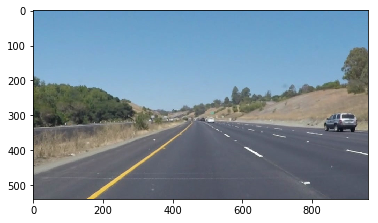

In [12]:
img_original = mpimg.imread(files[0])
print("The name of the first image is ", files[0],
         " with dimensions ",img_original.shape)
plt.imshow(img_original)

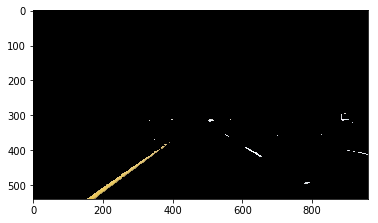

In [13]:
# Pick features of desired colors out of original image
color_filtered = cv2.addWeighted(
    yellow_image(img_original, yellow_threshold_lo, yellow_threshold_hi),1.0,  
    white_image(img_original, white_threshold_lo, white_threshold_hi), 1.0, 
    0.)
plt.imshow(color_filtered)

In [14]:
region_filtered = ROI(color_filtered, trap_top_width, 
                     trap_bottom_width,trap_height)

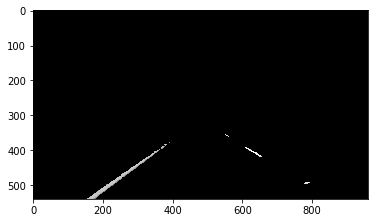

In [15]:
gray = grayscale(region_filtered)
plt.imshow(gray, cmap='gray')

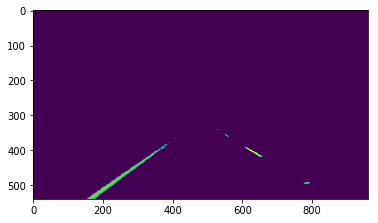

In [16]:
blur = cv2.GaussianBlur(gray, (3, 3), 0)
plt.imshow(blur)

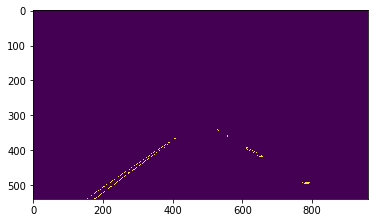

In [17]:
edged = canny(gray, low_threshold, high_threshold)
plt.imshow(edged)
    #img.save('/test_images_output/img.jpg', 'JPEG')

This is the  0 th input file, test_images/solidYellowCurve.jpg
Output image with lines overlaid:


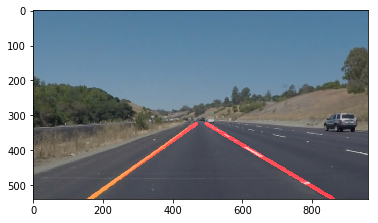

In [18]:
markers = hough_lines(edged, rho, theta, threshold, 
                      min_line_len, max_line_gap)

img_out = weighted_img(markers, img_original, α=0.8, β=1., λ=0.)

print("This is the ", n, "th input file,", files[0])
print("Output image with lines overlaid:")
plt.imshow(img_out)
Image.fromarray(img_out).save(mypath+str(n)+"out_file.jpeg")

# Part 2 Loops through the second image to the last file in the input directory and execute the pipeline on each of the image files

Add a pipeline function by collecting all of the stages of the pipeline

This is the  0 th input file, test_images/solidYellowCurve.jpg
Output image with lines overlaid:


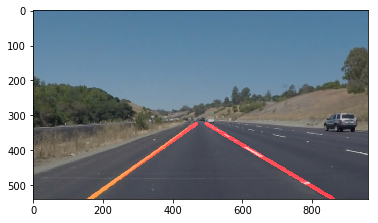

In [19]:
def pipeline(img_original):
        
    color_filtered = cv2.addWeighted(
                     yellow_image(img_original, 
                      yellow_threshold_lo, 
                      yellow_threshold_hi),
                      1.0,  
                     white_image(img_original, 
                      white_threshold_lo, 
                      white_threshold_hi), 
                      1.0, 
                     0.)
    
    region_filtered = ROI(color_filtered, trap_top_width, 
                      trap_bottom_width,trap_height)
    
    gray = grayscale(region_filtered)
    
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    
    edged = canny(gray, low_threshold, high_threshold)
    
    markers = hough_lines(edged, rho, theta, threshold, 
                      min_line_len, max_line_gap)

    return weighted_img(markers, img_original, α=0.8, β=1., λ=0.)

print("This is the ", n, "th input file,", files[0])
print("Output image with lines overlaid:")
plt.imshow(img_out)
Image.fromarray(img_out).save(mypath+str(n)+"out_file.jpeg")

In [20]:
# main()
for n in range(1, len(files)):
    
    image = mpimg.imread(files[n])
    
    image_lined = pipeline(image)
    
    Image.fromarray(image_lined).save(mypath+str(n)+"out_file.jpeg")

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

'''
To speed up the testing process you may want to try your pipeline 
on a shorter subclip of the video
To do so add .subclip(start_second,end_second) to the end of the 
line below. Where start_second and end_second are integer values 
representing the start and end of the subclip
You may also uncomment the following line for a subclip 
of the first 5 seconds
'''

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) 
#NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:09<00:00, 12.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 8.82 s, sys: 876 ms, total: 9.7 s
Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:46<00:00, 14.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 41.4 s, sys: 4.82 s, total: 46.2 s
Wall time: 46.8 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [27]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:26<00:00, 10.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 21.9 s, sys: 3.1 s, total: 25 s
Wall time: 28.7 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))